# Light curve minima fitter and O-C calculator

As shape of the minimum of pulsating stars varies by time, each minimum is fitted by a function individually in a given phase interval.

Errors are estimate with brute force, i.e. resampling observations n times with known observational errors.

OC fitter
To calculate the O-C diagram of a variable star, each minima can be fitted with a given function and associated OC errors are estimated in different ways.

Three kind of functions are available to fit each minimum. Polynomial, non-parametric and model (obtained from fitting the median of phase curve). Errors are from resampling the light curves using their brightness measurement errors.

In [1]:
from seismolab.OC import OCFitter

import numpy as np
import matplotlib.pyplot as plt

# Important notes, checklist:

- Check `filename` and `suffix` to load desired files
- Use magnitude-like scale __to fit true maxima__, use flux-like scale __to fit true minima__
- If period is not known, use `get_VSX` to query VSX
- If times are in JD, use `JD2BJD` to convert to BJD
- Check `sigma_clipping`'s `sigma` at first run to not to exclude useful points
 - __~4__ is OK if light curve is noisy (TESS) 
 - __~10__ is OK if light curve is very clean (Kepler/K2)
- Select function type (`fittype`) to be fitted
 - It can be `poly` , `nonparametric` or `model`
 - `poly` fits given order polynomial to each minimum individually
   - Requires the `order` to be set
 - `nonparametric` fits a smooth function to each minimum individually
   - Very sensitive to outliers!
   - Requires `smoothness` to be set.
 - `model` fits a smooth function to the median of phase folded light curve
   - The resulted function is shifted to each minimum
   - Error estimation is very slow, set `samplings` to ~100.
- Check minimum fit result at first run
 - Check `order` of polynomial to be fitted to each minimum (if `fittype` is `poly`)
 - Check `smoothness` of function to be fitted to each minimum (if `fittype` is `nonparametric`)
   - __~1:__ to follow small scale variations, __>1 (e.g. 1.5):__ to fit really smooth function
 - `phase_interval` is the phase interval, which is selected around an expected minimum to fit the selected function

# Example stars (generated from real K2 observations):
- 1. variable star with stable pulsation (flat O-C)
- 2. variable star with periodic O-C variation: A=0.02 days, P=100 days

#### Input data informations

#### Loop over all stars

Check commented parts to see if they are needed

In [71]:
lc = np.loadtxt("https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:HLSP/qlp/s0001/0000/0000/4041/2372/hlsp_qlp_tess_ffi_s0001-0000000040412372_tess_v01_llc.txt", delimiter=',').T

# Store results in separate arrays for clarity
time       = lc[0]
flux = -np.log10(lc[1])+25
fluxerr = np.ones_like(time)*0.01

period = 0.409837

Calculating minima times...


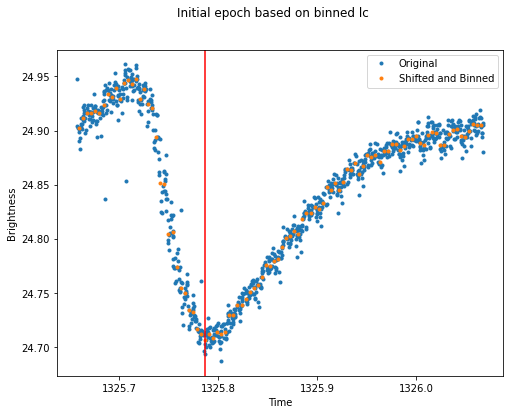

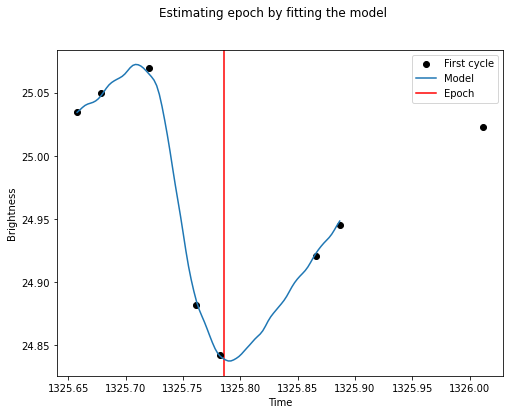

Fitting cycles:   0%|                                        | 0/57 [00:00<?, ?it/s]

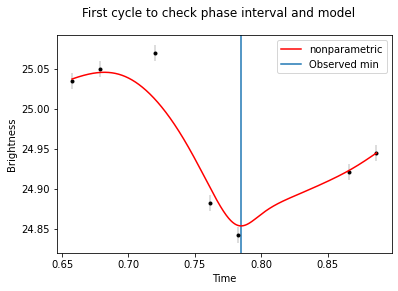

Fitting cycles:  95%|█████████████████████████████▎ | 54/57 [00:09<00:00,  5.56it/s]

Done!


In [72]:
# Initialize fitter
fitter = OCFitter(time,flux,fluxerr, period)

# Calculate minimum times
mintimes,mintimes_err = fitter.fit_minima(fittype='nonparametric', phase_interval=0.4,
                                          order=7, smoothness=1.0,
                                          npools=-1, samplings=10,
                                          showfirst=True, saveplot=False, showplot=False,
                                          filename='name',
                                         debug=False)

Calculating O-C...


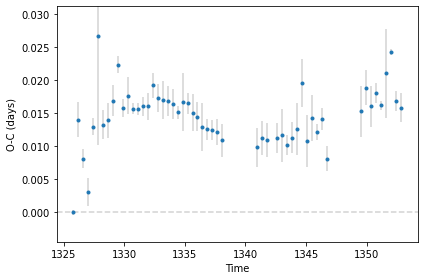

In [73]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

Calculating minima times...


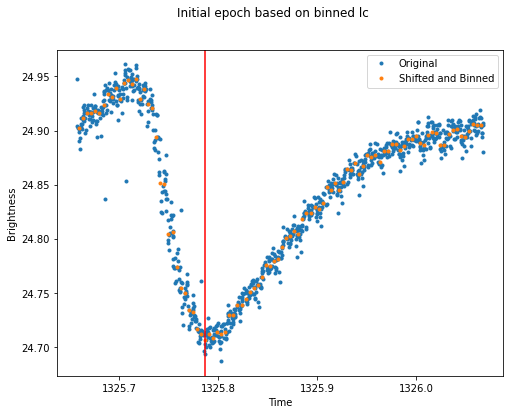

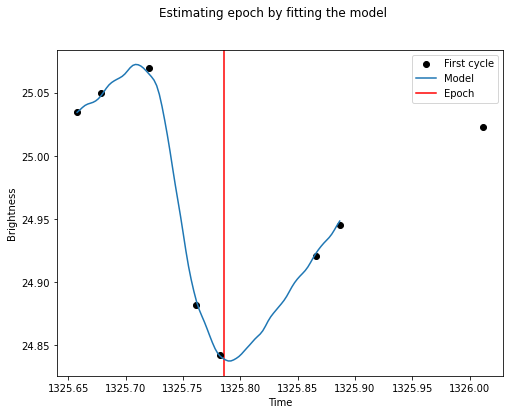

Fitting cycles:   0%|                                        | 0/57 [00:00<?, ?it/s]

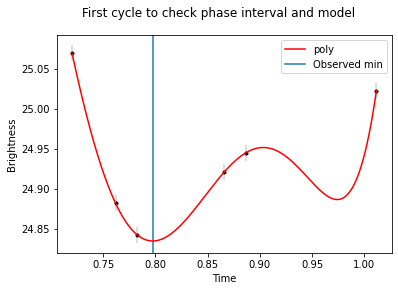

Fitting cycles:  93%|████████████████████████████▊  | 53/57 [00:02<00:00, 26.01it/s]

Done!


In [74]:
# Initialize fitter
fitter = OCFitter(time,flux,fluxerr, period)

# Calculate minimum times
mintimes,mintimes_err = fitter.fit_minima(fittype='poly', phase_interval=0.4,
                                          order=7, smoothness=1.0,
                                          npools=-1, samplings=10,
                                          showfirst=True, saveplot=False, showplot=False,
                                          filename='name',
                                         debug=False)

Calculating O-C...


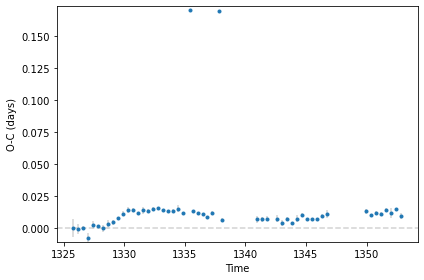

In [75]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

(-0.005, 0.03)

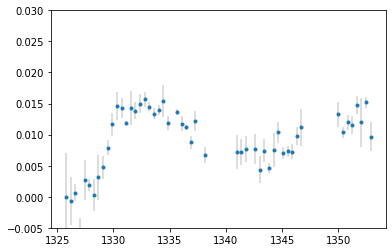

In [76]:
plt.errorbar(OC[:,0],OC[:,1],OC_err,fmt='.',ecolor="lightgray")
plt.ylim(-0.005,0.03)

Calculating minima times...


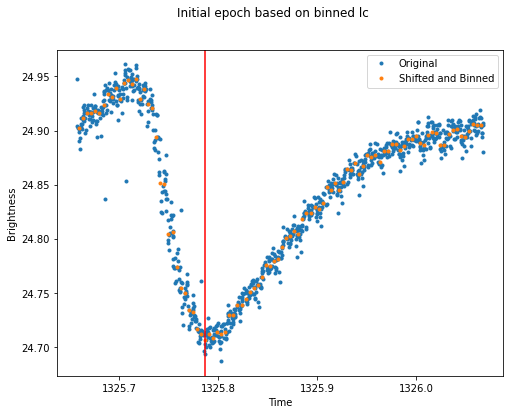

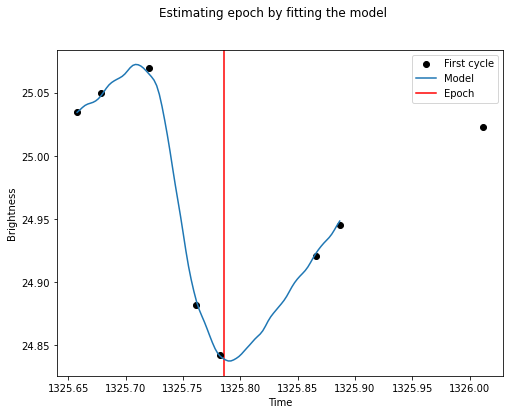

Fitting cycles:   0%|                                        | 0/57 [00:00<?, ?it/s]

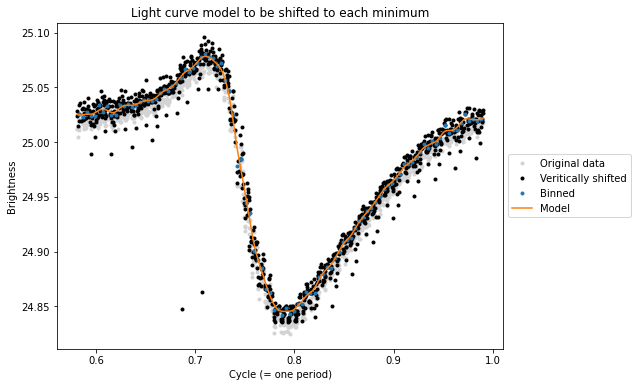

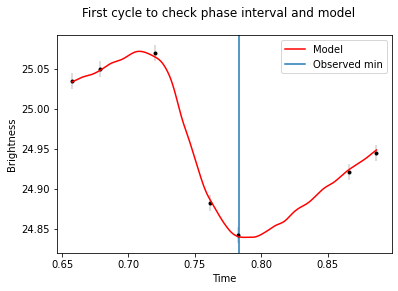

Fitting cycles:  96%|█████████████████████████████▉ | 55/57 [00:36<00:01,  1.50it/s]

Done!


In [77]:
# Initialize fitter
fitter = OCFitter(time,flux,fluxerr, period)

# Calculate minimum times
mintimes,mintimes_err = fitter.fit_minima(fittype='model', phase_interval=0.4,
                                          order=7, smoothness=1.0,
                                          npools=-1, samplings=10,
                                          showfirst=True, saveplot=False, showplot=False,
                                          filename='name',
                                         debug=False)

Calculating O-C...


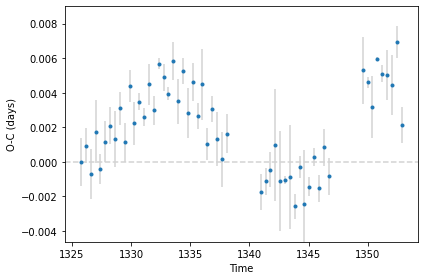

In [78]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

(-0.005, 0.03)

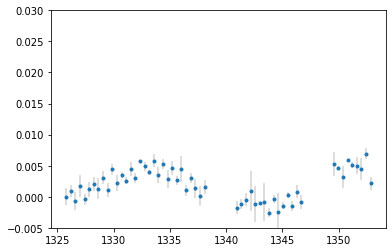

In [79]:
plt.errorbar(OC[:,0],OC[:,1],OC_err,fmt='.',ecolor="lightgray")
plt.ylim(-0.005,0.03)

In [58]:
lc = np.loadtxt("/Volumes/LaCie/work/short_period_RGs/KIC_7466053_DF_Cyg/k1.2d.myown2.ossz.mag_corrected2.dat").T

time       = lc[0]
flux = -lc[1]+25
fluxerr = np.ones_like(time)*0.0001

period = 49.99#24.925*2

Fitting cycles:  17%|█████▎                          | 3/18 [02:04<10:21, 41.46s/it]


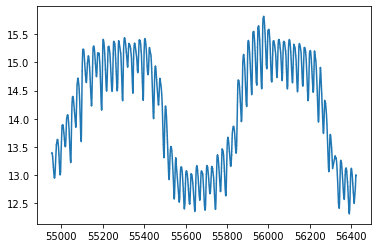

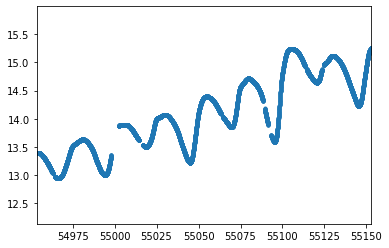

In [31]:
plt.errorbar(time,flux,fluxerr,fmt='-',ecolor='lightgray')
plt.show()

plt.errorbar(time,flux,fluxerr,fmt='.',ecolor='lightgray')
plt.xlim(time[0],time[0]+4*period)
plt.show()

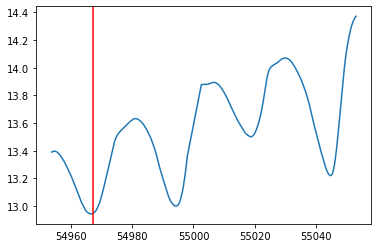

In [55]:
um = (time>time[0]) & (time<time[0]+2*period)
plt.plot(time[um],flux[um])
plt.axvline(54967+0*period,c='r')
plt.show()

Calculating minima times...


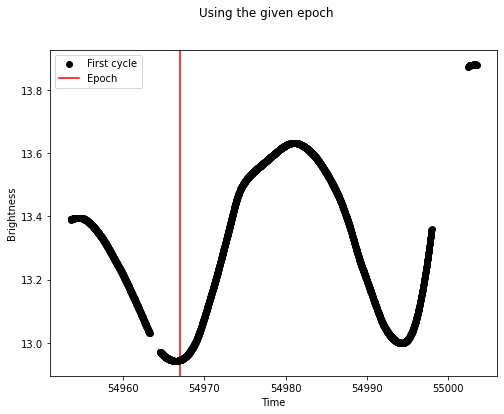

Fitting cycles:   0%|                                        | 0/17 [00:00<?, ?it/s]

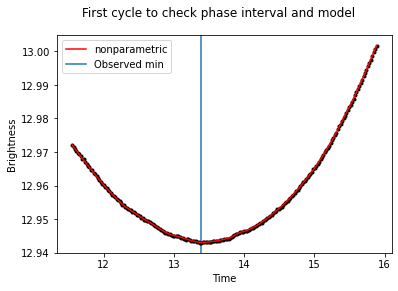

Fitting cycles:   6%|█▉                              | 1/17 [00:00<00:04,  3.46it/s]

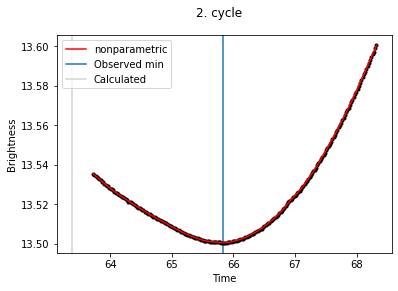

Fitting cycles:  12%|███▊                            | 2/17 [00:00<00:04,  3.31it/s]

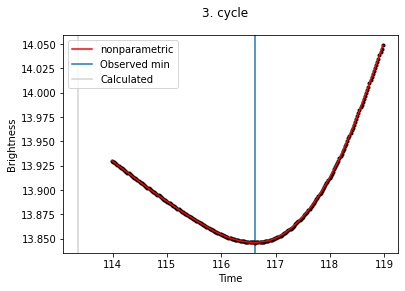

Fitting cycles:  18%|█████▋                          | 3/17 [00:00<00:04,  3.22it/s]

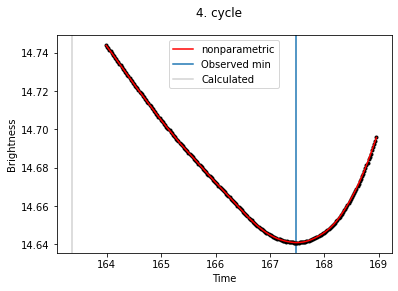

Fitting cycles:  24%|███████▌                        | 4/17 [00:01<00:04,  3.19it/s]

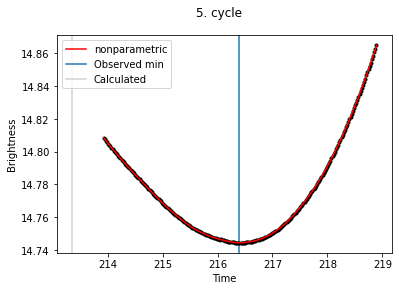

Fitting cycles:  29%|█████████▍                      | 5/17 [00:01<00:03,  3.26it/s]

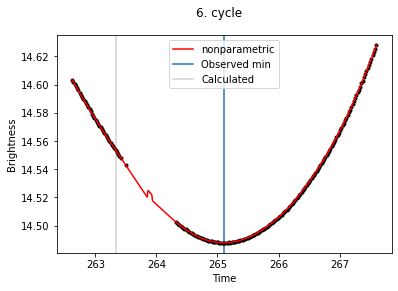

Fitting cycles:  35%|███████████▎                    | 6/17 [00:01<00:03,  3.21it/s]

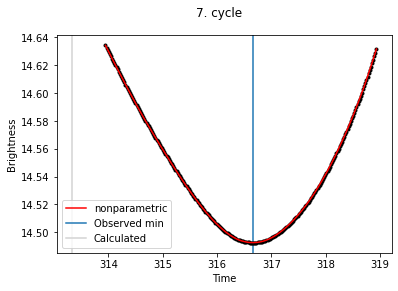

Fitting cycles:  41%|█████████████▏                  | 7/17 [00:02<00:03,  3.19it/s]

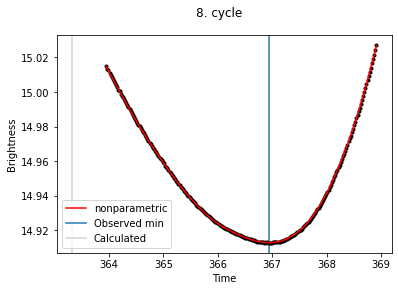

Fitting cycles:  47%|███████████████                 | 8/17 [00:02<00:02,  3.26it/s]

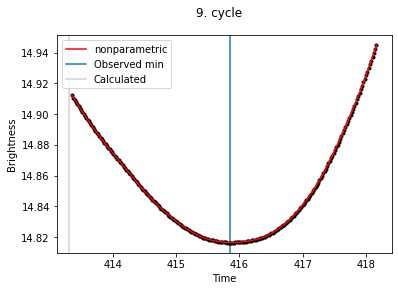

Fitting cycles:  53%|████████████████▉               | 9/17 [00:02<00:02,  3.19it/s]

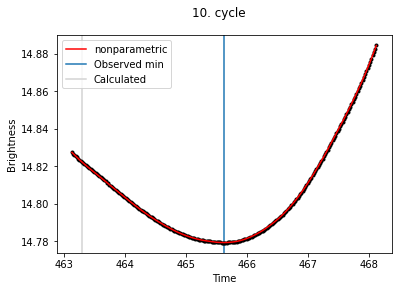

Fitting cycles:  59%|██████████████████▏            | 10/17 [00:03<00:02,  3.16it/s]

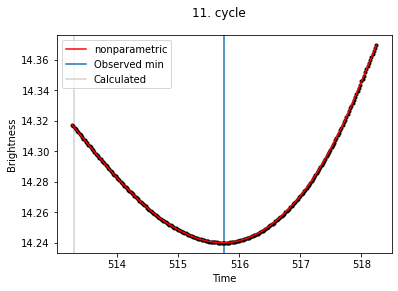

Fitting cycles:  65%|████████████████████           | 11/17 [00:03<00:01,  3.15it/s]

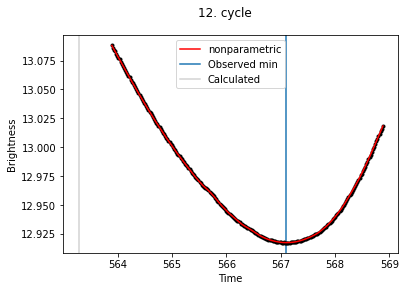

Fitting cycles:  71%|█████████████████████▉         | 12/17 [00:03<00:01,  3.11it/s]

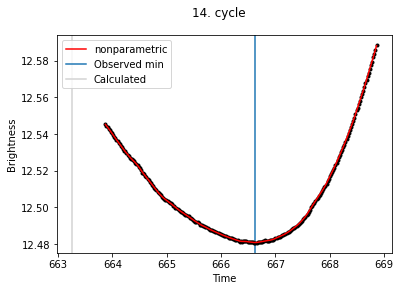

Fitting cycles:  76%|███████████████████████▋       | 13/17 [00:04<00:01,  3.05it/s]

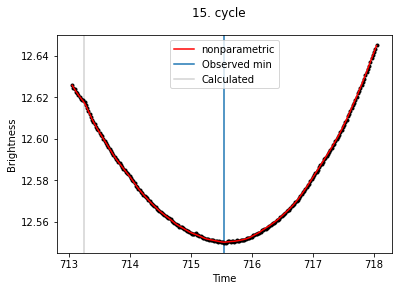

Fitting cycles:  82%|█████████████████████████▌     | 14/17 [00:04<00:00,  3.12it/s]

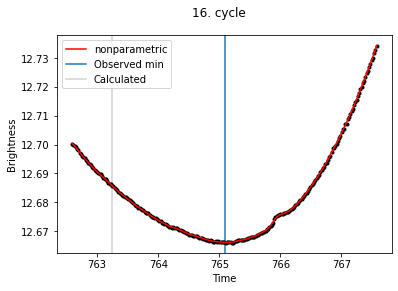

Fitting cycles:  88%|███████████████████████████▎   | 15/17 [00:04<00:00,  3.13it/s]

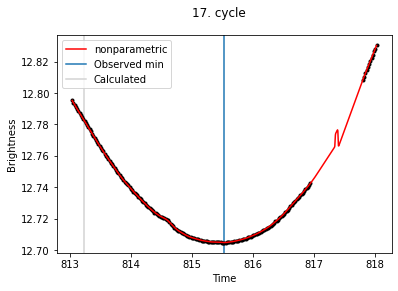

Fitting cycles:  94%|█████████████████████████████▏ | 16/17 [00:05<00:00,  3.12it/s]

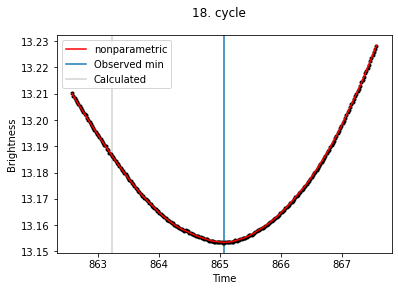

Fitting cycles: 100%|███████████████████████████████| 17/17 [00:05<00:00,  3.14it/s]

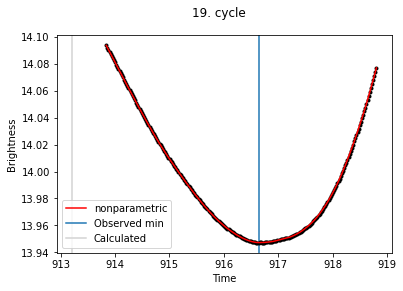

Fitting cycles: 18it [00:05,  2.76it/s]                                             

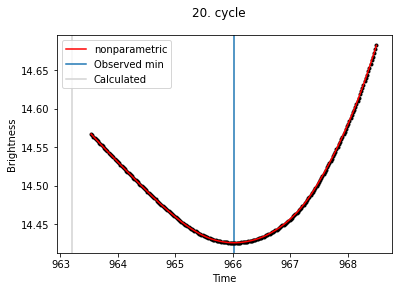

Fitting cycles: 19it [00:06,  2.95it/s]

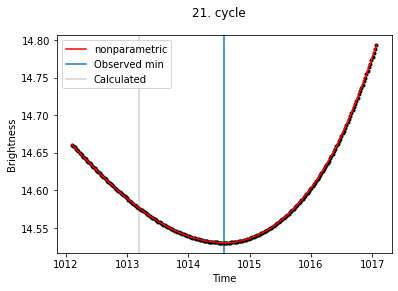

Fitting cycles: 20it [00:06,  3.00it/s]

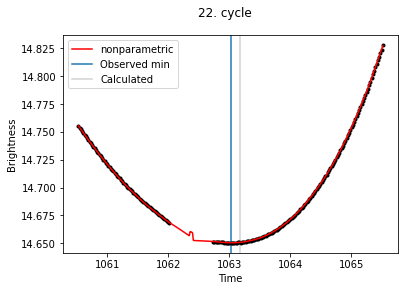

Fitting cycles: 21it [00:06,  3.10it/s]

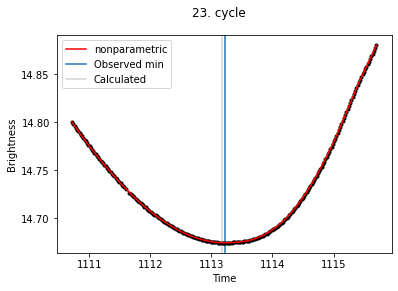

Fitting cycles: 22it [00:07,  3.25it/s]

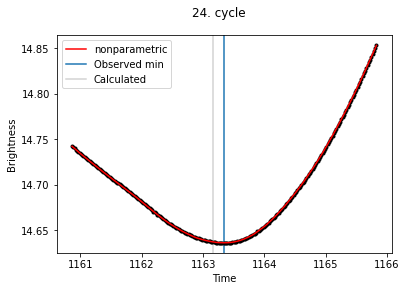

Fitting cycles: 23it [00:07,  3.30it/s]

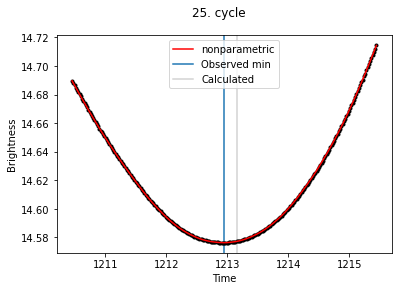

Fitting cycles: 24it [00:07,  3.29it/s]

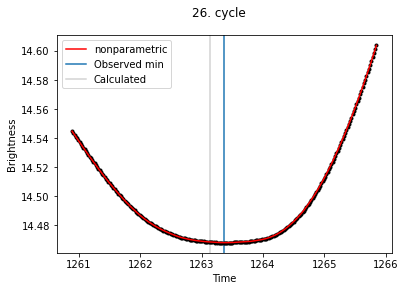

Fitting cycles: 25it [00:07,  3.24it/s]

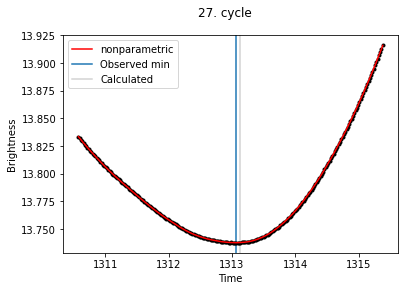

Fitting cycles: 26it [00:08,  3.30it/s]

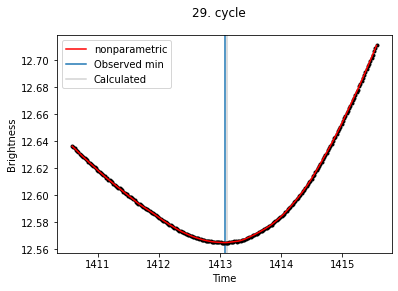

Fitting cycles: 27it [00:08,  3.17it/s]

Done!


In [69]:
# Initialize fitter
fitter = OCFitter(time,flux,fluxerr, period)

# Calculate minimum times
mintimes,mintimes_err = fitter.fit_minima(fittype='nonparametric', phase_interval=0.05,
                                          order=7, smoothness=2.0,
                                          npools=-1, samplings=2,
                                          epoch=54967,
                                          showfirst=True, saveplot=False, showplot=True,
                                          filename='name',
                                         debug=False)

Calculating O-C...


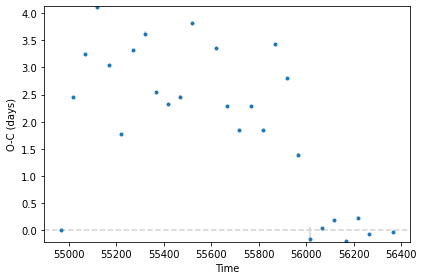

In [70]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

Calculating O-C...


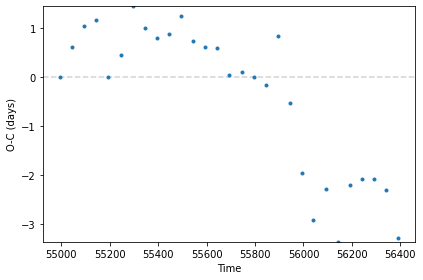

In [61]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

Calculating O-C...


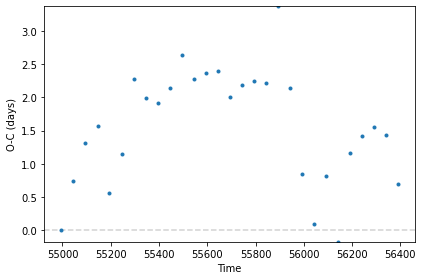

In [20]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

In [80]:
lc = np.loadtxt("https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:HLSP/qlp/s0001/0000/0000/4041/2372/hlsp_qlp_tess_ffi_s0001-0000000040412372_tess_v01_llc.txt", delimiter=',').T

# Store results in separate arrays for clarity
time       = lc[0]
flux = -np.log10(lc[1])+25
fluxerr = np.ones_like(time)*0.01

period = 0.409837

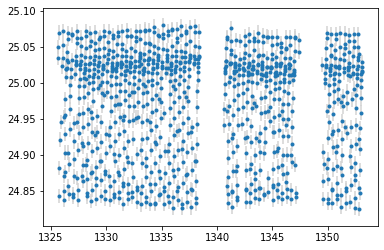

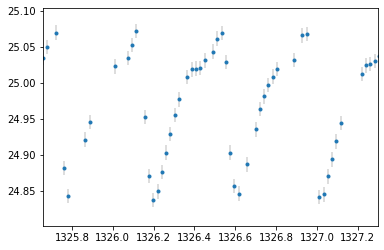

In [81]:
plt.errorbar(time,flux,fluxerr,fmt='.',ecolor='lightgray')
plt.show()

plt.errorbar(time,flux,fluxerr,fmt='.',ecolor='lightgray')
plt.xlim(time[0],time[0]+4*period)
plt.show()

Calculating minima times...


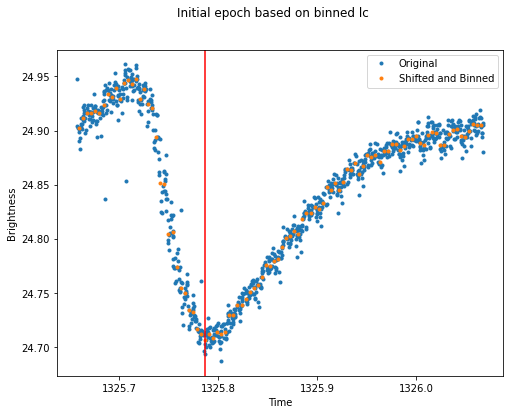

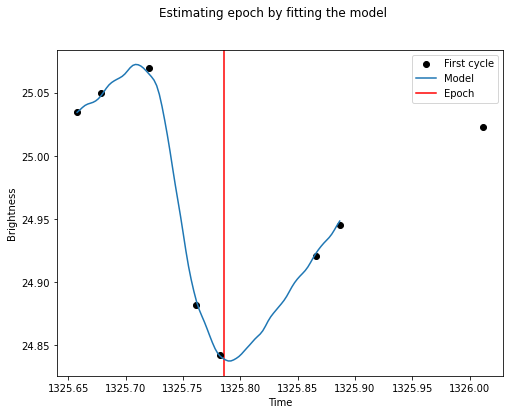

Fitting cycles:   0%|                                        | 0/57 [00:00<?, ?it/s]

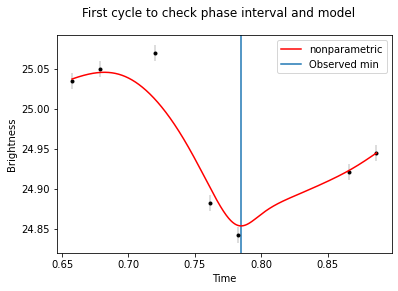

Fitting cycles:  96%|█████████████████████████████▉ | 55/57 [00:09<00:00,  5.57it/s]

Done!


In [82]:
# Initialize fitter
fitter = OCFitter(time,flux,fluxerr, period)

# Calculate minimum times
mintimes,mintimes_err = fitter.fit_minima(fittype='nonparametric', phase_interval=0.5,
                                          order=7, smoothness=1.0,
                                          npools=-1, samplings=10,
                                          showfirst=True, saveplot=False, showplot=False,
                                          filename='name',
                                         debug=False)

Calculating O-C...


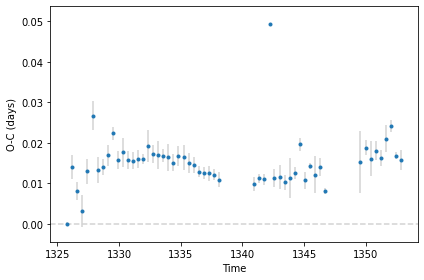

/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2007: RuntimeWarning: overflow encountered in true_divide
  s = divide(1, s, where=large, out=s)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2046: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2047: RuntimeWarning: invalid value encountered in double_scalars
  q = 2.0 * (q - r)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2007: RuntimeWarning: overflow encountered in true_divide
  s = divide(1, s, where=large, out=s)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2046: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/batty/opt/miniconda3/

In [83]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

Calculating minima times...


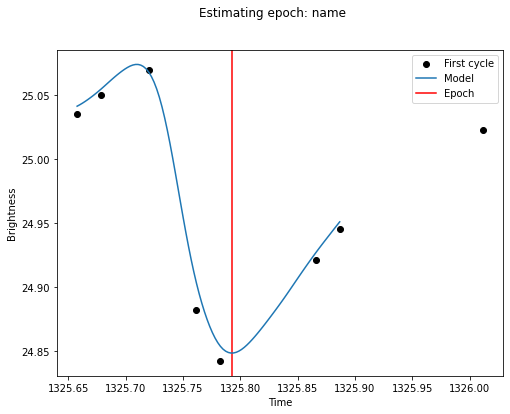

  0%|                                                        | 0/57 [00:00<?, ?it/s]

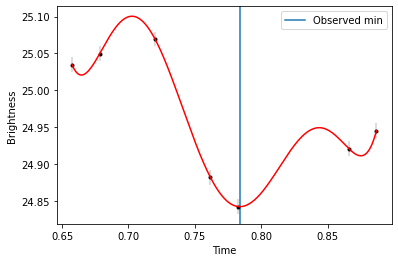

 93%|███████████████████████████████████████████▋   | 53/57 [00:01<00:00, 28.83it/s]


In [8]:
# Initialize fitter
fitter = OCFitter(time,flux,fluxerr, period)

# Calculate minimum times
mintimes,mintimes_err = fitter.fit_minima(fittype='poly', phase_interval=0.5,
                                          order=7, smoothness=1.0,
                                          npools=-1, samplings=10,
                                          showfirst=True, saveplot=False, showplot=False,
                                          filename='name',
                                         debug=False)

Calculating O-C...


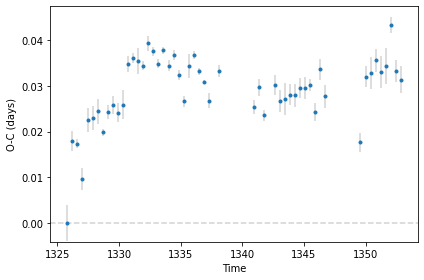

In [9]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

Calculating minima times...


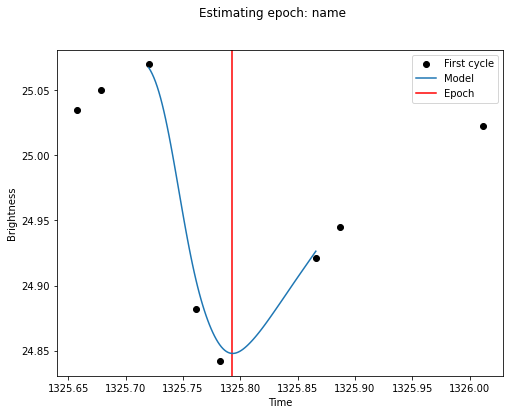


  0%|                                                        | 0/57 [00:00<?, ?it/s]WARNING: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]


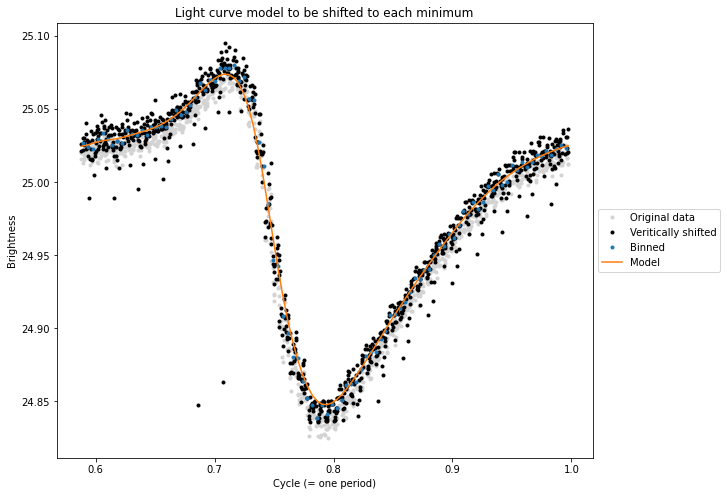

KeyboardInterrupt: 

In [7]:
# Initialize fitter
fitter = OCFitter(time,flux,fluxerr, period)

# Calculate minimum times
mintimes,mintimes_err = fitter.fit_minima(fittype='model', phase_interval=0.2,
                                          order=7, smoothness=1.0,
                                          npools=-1, samplings=10,
                                          showfirst=True, saveplot=False, showplot=True,
                                          filename='name',
                                         debug=False)

Calculating O-C...


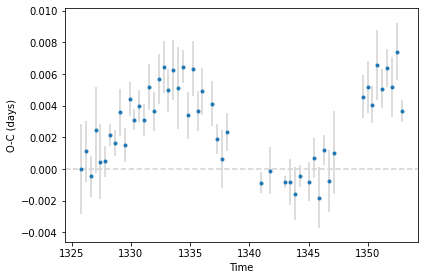

In [13]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

Calculating O-C...


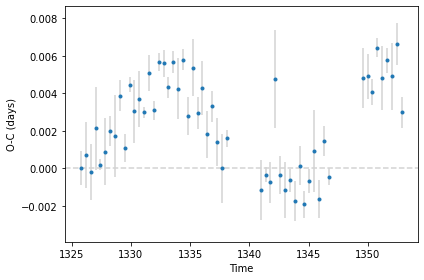

In [5]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

Calculating minima times...


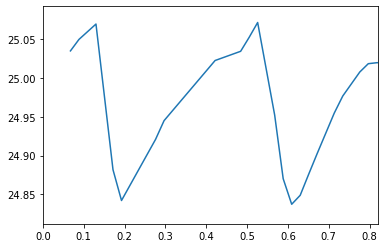

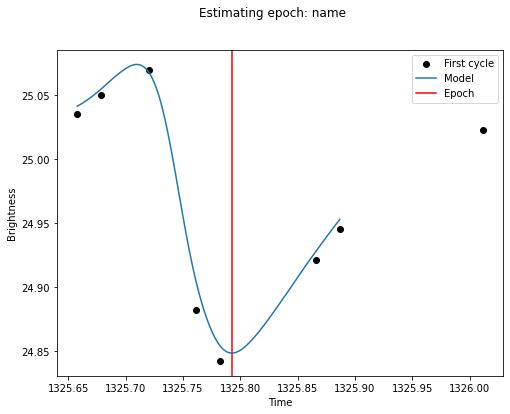

  0%|                                                        | 0/57 [00:00<?, ?it/s]

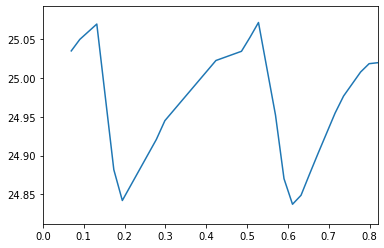

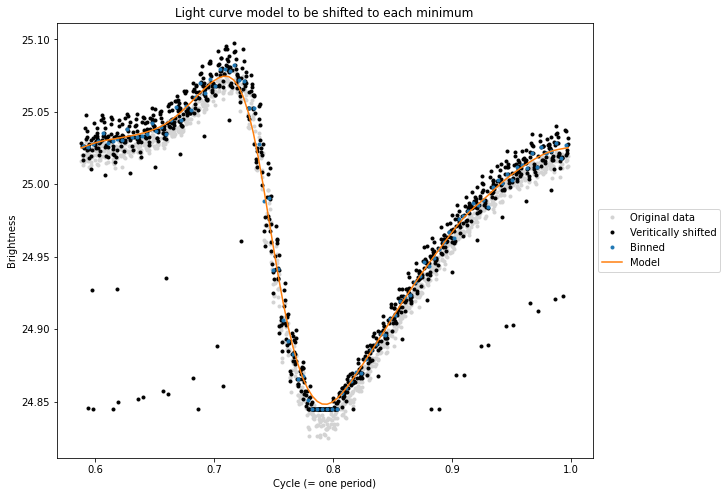

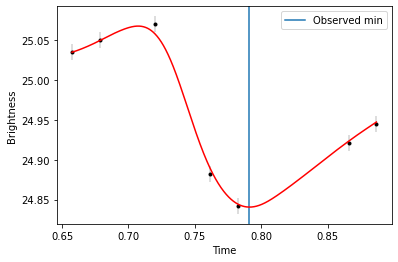

 96%|█████████████████████████████████████████████▎ | 55/57 [00:34<00:01,  1.61it/s]
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2007: RuntimeWarning: overflow encountered in true_divide
  s = divide(1, s, where=large, out=s)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2010: RuntimeWarning: invalid value encountered in matmul
  res = matmul(transpose(vt), multiply(s[..., newaxis], transpose(u)))
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2217: Ru

In [4]:
# Initialize fitter
fitter = OCFitter(time,flux,fluxerr, period)

# Calculate minimum times
mintimes,mintimes_err = fitter.fit_minima(fittype='model', phase_interval=0.5,
                                          order=7, smoothness=1.0,
                                          npools=-1, samplings=10,
                                          showfirst=True, saveplot=False, showplot=False,
                                          filename='name',
                                         debug=False)

Calculating minima times...


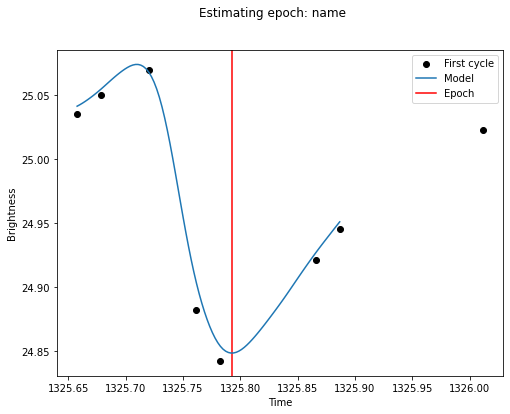

  0%|                                                        | 0/57 [00:00<?, ?it/s]

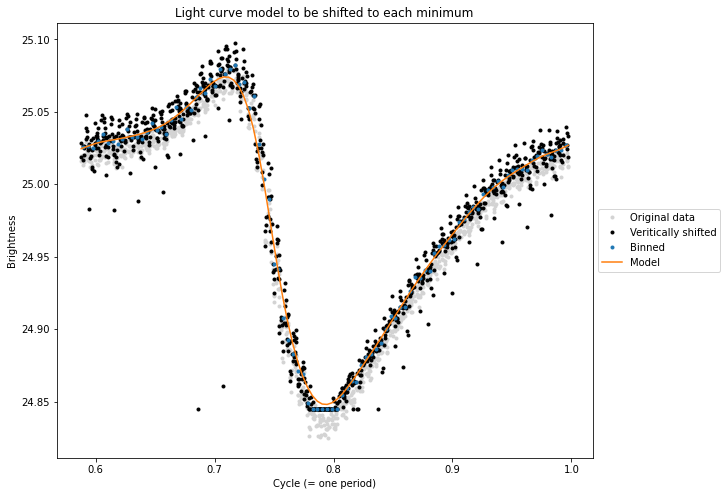

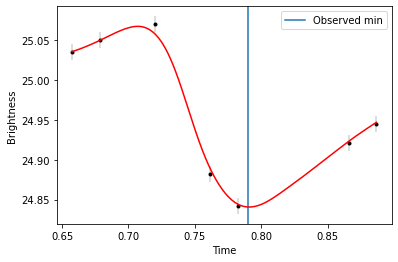

 96%|█████████████████████████████████████████████▎ | 55/57 [00:34<00:01,  1.61it/s]
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2007: RuntimeWarning: overflow encountered in true_divide
  s = divide(1, s, where=large, out=s)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2217: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2010: RuntimeWarning: invalid value encoun

In [3]:
# Initialize fitter
fitter = OCFitter(time,flux,fluxerr, period)

# Calculate minimum times
mintimes,mintimes_err = fitter.fit_minima(fittype='model', phase_interval=0.5,
                                          order=7, smoothness=1.0,
                                          npools=-1, samplings=10,
                                          showfirst=True, saveplot=False, showplot=False,
                                          filename='name',
                                         debug=False)

Calculating O-C...


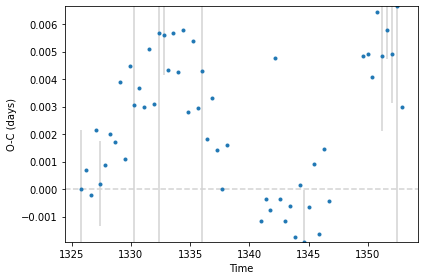

In [13]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

Calculating O-C...


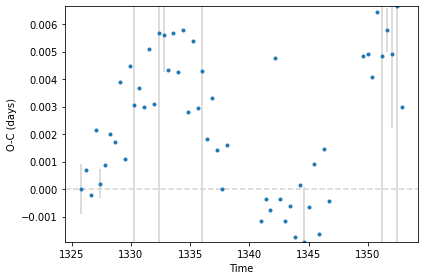

In [5]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

(-0.005, 0.052)

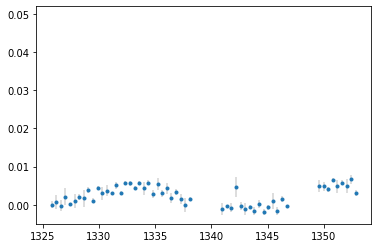

In [7]:
plt.errorbar(OC[:,0],OC[:,1],OC_err,fmt='.',ecolor="lightgray")
plt.ylim(-0.005,0.052)

(-0.005, 0.052)

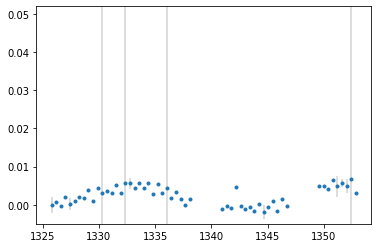

/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2007: RuntimeWarning: overflow encountered in true_divide
  s = divide(1, s, where=large, out=s)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2010: RuntimeWarning: invalid value encountered in matmul
  res = matmul(transpose(vt), multiply(s[..., newaxis], transpose(u)))
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2217: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1

In [14]:
plt.errorbar(OC[:,0],OC[:,1],OC_err,fmt='.',ecolor="lightgray")
plt.ylim(-0.005,0.052)

(-0.005, 0.052)

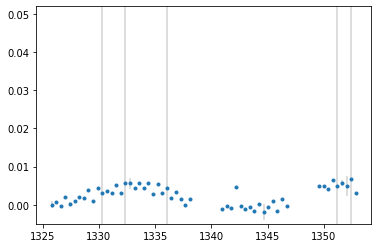

/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2007: RuntimeWarning: overflow encountered in true_divide
  s = divide(1, s, where=large, out=s)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/numpy/linalg/linalg.py:2010: RuntimeWarning: invalid value encountered in matmul
  res = matmul(transpose(vt), multiply(s[..., newaxis], transpose(u)))
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/batty/opt/miniconda3/envs/seismolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:2217: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1

In [11]:
plt.errorbar(OC[:,0],OC[:,1],OC_err,fmt='.',ecolor="lightgray")
plt.ylim(-0.005,0.052)

Calculating O-C...


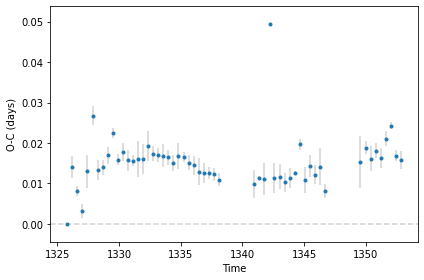

In [7]:
# Calculate O-C
OC,OC_err = fitter.calculate_OC(mintimes,period,min_times_err=mintimes_err,
                                saveplot=False,showplot=True,
                                saveOC=False,filename='name')

(-0.01, 0.01)

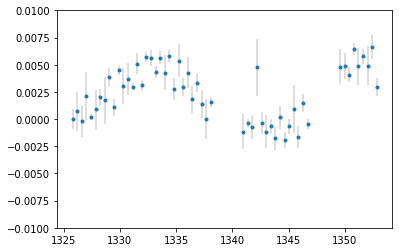

In [11]:
plt.errorbar(OC[:,0],OC[:,1],OC_err,fmt='.',ecolor="lightgray")
plt.ylim(-0.01,0.01)